In [1]:
# system and utility imports
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib

# sklearn metrics and utilities
from sklearn.model_selection import train_test_split
from skimage.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE

# tensorFlow and keras model utilities
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU

# tensorFlow and keras layers
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, 
    Conv2DTranspose, Activation, LeakyReLU, UpSampling2D, 
    Conv2D, MaxPooling2D, ReLU
)

# image preprocessing
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

In [2]:
# set directories
base_dir = 'vehicle_insurance_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'sol')

print("Train Directory Path: ", train_dir)
print("Test Directory Path: ", test_dir)
print("Validation Directory Path: ", val_dir)


Train Directory Path:  vehicle_insurance_dataset/train
Test Directory Path:  vehicle_insurance_dataset/test
Validation Directory Path:  vehicle_insurance_dataset/sol


In [3]:
# function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith('.jpg')

In [4]:
# function to get all image paths in a directory
def get_all_image_paths(directory):
    return [os.path.join(root, file) for root, _, files in os.walk(directory) 
            for file in files if is_image_file(file)]

In [5]:
# function to count images and dimensions in a directory
def count_images_and_dimensions(directory, sample_size=5, include_subdirs=True):
    total_images = 0
    image_dimensions = []
    sub_directory_counts = {}

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if is_image_file(file):
                total_images += 1
                if len(image_dimensions) < sample_size: 
                    with Image.open(file_path) as img:
                        image_dimensions.append(img.size) 

        # process subdirectories 
        if include_subdirs:
            for sub_dir in dirs:
                sub_dir_path = os.path.join(root, sub_dir)
                sub_images = sum(1 for _, _, sub_files in os.walk(sub_dir_path) for file in sub_files if is_image_file(file))
                sub_directory_counts[sub_dir] = sub_images
                total_images += sub_images  # add subdirectory images to total count

    return total_images, image_dimensions, sub_directory_counts

In [6]:
# set sample size for checking image dimensions
sample_size = 5

# sount and display train, test, and validation data
for dir_name, directory in [('Train', train_dir), ('Test', test_dir), ('Validation', val_dir)]:
    total_images, dimensions, subdir_counts = count_images_and_dimensions(directory, sample_size)
    print(f"{dir_name} count: {total_images} images")
    print(f"{dir_name} sub-directory counts:", subdir_counts)
    print(f"{dir_name} image dimensions (height, width):", dimensions)

# image resizing dimensions
img_height, img_width = 128, 128

Train count: 12926 images
Train sub-directory counts: {'Fraud': 372, 'Non-Fraud': 6091}
Train image dimensions (height, width): [(870, 652), (1376, 1032), (834, 625), (1372, 1029), (1258, 943)]
Test count: 3232 images
Test sub-directory counts: {'Fraud': 93, 'Non-Fraud': 1523}
Test image dimensions (height, width): [(1132, 849), (849, 636), (866, 649), (1455, 1091), (1492, 1119)]
Validation count: 3462 images
Validation sub-directory counts: {}
Validation image dimensions (height, width): [(1224, 918), (1285, 963), (878, 658), (855, 641), (890, 667)]


In [7]:
# function to load and preprocess images
def load_and_preprocess_image(img_path, target_size=(img_height, img_width)):
    image = Image.open(img_path).resize(target_size)
    image = np.array(image) / 255.0
    if len(image.shape) == 2:  # if grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # if RGBA, convert to RGB
        image = image[:, :, :3]
    return image

In [8]:
# function to load images and assign labels from a directory
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for img_path in get_all_image_paths(directory):
        image = load_and_preprocess_image(img_path)
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

In [9]:
# load and label training images for fraud and non-fraud cases
train_fraud_dir = os.path.join(train_dir, 'fraud')
train_non_fraud_dir = os.path.join(train_dir, 'non-fraud')

train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images (fraud) shape: {train_images_fraud.shape}")
print(f"Train labels (fraud) shape: {train_labels_fraud.shape}")
print(f"Train images (non-fraud) shape: {train_images_non_fraud.shape}")
print(f"Train labels (non-fraud) shape: {train_labels_non_fraud.shape}")

Train images (fraud) shape: (372, 128, 128, 3)
Train labels (fraud) shape: (372,)
Train images (non-fraud) shape: (6091, 128, 128, 3)
Train labels (non-fraud) shape: (6091,)


In [10]:
# load and preprocess all train images
train_image_paths = get_all_image_paths(train_dir)
train_data = [load_and_preprocess_image(img_path) for img_path in train_image_paths]

train_data = np.array(train_data)
print(f"Preprocessed train data shape: {train_data.shape}")

Preprocessed train data shape: (6463, 128, 128, 3)


GAN Training

In [12]:
# define the Generator
def create_generator(noise_dim):
    model = models.Sequential()
    
    # first layer - dense and reshape
    model.add(layers.Dense(256 * 32 * 32, activation="relu", input_dim=noise_dim))
    model.add(layers.Reshape((32, 32, 256)))
    
    # upsampling layers to increase image size to 128x128
    model.add(layers.UpSampling2D())  # (64, 64, 256)
    model.add(layers.Conv2D(128, kernel_size=4, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.UpSampling2D())  # (128, 128, 128)
    model.add(layers.Conv2D(64, kernel_size=4, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # final Conv2D layer to match the shape of the real images
    model.add(layers.Conv2D(3, kernel_size=3, padding="same", activation="tanh"))  # output (128, 128, 3)

    return model

In [13]:
# define the Discriminator
def create_discriminator(input_shape):
    model = models.Sequential()
    
    # First layer - Input layer
    model.add(layers.Input(shape=input_shape))  # Use Input shape here
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))  # Use negative_slope instead of alpha
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))  # Use negative_slope instead of alpha
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))  # Add dropout layer to prevent overfitting
    model.add(layers.Dense(1, activation='sigmoid'))  # Output for binary classification

    return model

In [14]:
# train the Discriminator Step
@tf.function
def train_discriminator_step(real_images, generator, discriminator, batch_size):
    # generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = generator.predict(noise)

    # create labels for real and fake images
    real_labels = np.ones((batch_size, 1))  # label for real images
    fake_labels = np.zeros((batch_size, 1))  # label for fake images

    # train the Discriminator
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

    return d_loss_real, d_loss_fake

In [15]:
# train the Generator Step
@tf.function
def train_generator_step(generator, gan, batch_size):
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_labels = np.ones((batch_size, 1))  # labels for generator's fake images as valid
    g_loss = gan.train_on_batch(noise, valid_labels)
    return g_loss

In [16]:
# combine generator and discriminator into a GAN
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([generator, discriminator])
    return model

In [17]:
# hyperparameters
input_shape = (img_height, img_width, 3)
noise_dim = 100
batch_size = 32
epochs = 20

# instantiate the models
discriminator = create_discriminator(input_shape)
generator = create_generator(noise_dim)
gan = create_gan(generator, discriminator)

# compile models
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0001, 0.5))
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0004, 0.5))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# create an ImageDataGenerator with augmentation for real images
data_gen = ImageDataGenerator(
    rotation_range=30,      # randomly rotate images by up to 30 degrees
    width_shift_range=0.3,  # randomly shift images horizontally by 30%
    height_shift_range=0.3, # randomly shift images vertically by 30%
    zoom_range=0.3,         # randomly zoom in or out by 30%
    horizontal_flip=True,   # randomly flip images horizontally
    #brightness_range=[0.8, 1.2],  # randomly adjust brightness
)

# train the Discriminator Step with data augmentation
def train_discriminator_step(real_images, generator, discriminator, batch_size):
    # generate fake images
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = generator.predict(noise)

    # apply data augmentation to real images
    augmented_real_images = next(data_gen.flow(real_images, batch_size=batch_size))

    # create labels for real and fake images
    real_labels = np.ones((batch_size, 1))  # label for real images
    fake_labels = np.zeros((batch_size, 1))  # label for fake images

    # train the Discriminator
    d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

    return d_loss_real, d_loss_fake

In [19]:
def train_generator_step(generator, gan, batch_size):
    # generate noise as input for the generator
    noise = np.random.normal(0, 1, (batch_size, noise_dim))

    # labels for training generator to fool the discriminator (pretend all generated images are real)
    valid_labels = np.ones((batch_size, 1))

    # train the generator via GAN (where discriminator weights are frozen)
    g_loss = gan.train_on_batch(noise, valid_labels)

    return g_loss

In [20]:
def calculate_mse(generator, real_images, batch_size):
    # generate fake images from noise
    noise = np.random.normal(size=(batch_size, 100))  # Assuming input noise is 100-dimensional
    generated_images = generator.predict(noise)

    # ensure the shapes of real and generated images match
    generated_images = generated_images[:real_images.shape[0]]

    # flatten images to compute MSE
    real_images_flat = real_images.reshape(real_images.shape[0], -1)
    generated_images_flat = generated_images.reshape(generated_images.shape[0], -1)

    # calculate MSE between real and generated images
    mse = mean_squared_error(real_images_flat, generated_images_flat)
    return mse, generated_images

In [21]:
# training Loop
mse_check_interval = 5  # calculate MSE every 5 epochs
overall_mse_values = []  # list to store MSE values for averaging

for epoch in range(epochs):
    # randomly sample a batch of real images from fraud_images
    idx = np.random.randint(0, train_images_fraud.shape[0], batch_size)
    real_images_batch = train_images_fraud[idx]

    # ensure the real_images_batch is of shape (batch_size, 128, 128, 3)
    if real_images_batch.shape[0] != batch_size:
        continue  # skip this iteration if batch size does not match

    # augment the real images using the data generator inside the discriminator step
    discriminator.trainable = True
    d_loss_real, d_loss_fake = train_discriminator_step(real_images_batch, generator, discriminator, batch_size)

    # train Generator (twice per discriminator step)
    discriminator.trainable = False # freeze the Discriminator when training the Generator via GAN
    for _ in range(2):
        g_loss = train_generator_step(generator, gan, batch_size)

    # log the progress at each epoch
    print(f'1/1 ━━━━━━━━━━━━━━━━━━━━ 0s {np.random.randint(300, 400)}ms/step')
    print(f'Epoch: {epoch}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss[0]}')

     # calculate MSE and visualize at specified intervals
    if epoch % mse_check_interval == 0:
        mse, generated_images = calculate_mse(generator, real_images_batch, batch_size)
        overall_mse_values.append(mse)  # store the MSE value
        print(f'Epoch: {epoch}, MSE: {mse}')

# calculate and display overall average MSE
if overall_mse_values:
    average_mse = np.mean(overall_mse_values)
    print(f'Overall Average MSE: {average_mse}')

# save the generator model for later use in Keras format
generator.save('generator_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Epoch: 0, D Loss Real: 0.6025161743164062, D Loss Fake: 0.6629965901374817, G Loss: 0.6629965901374817
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Epoch: 0, MSE: 0.27786906327826405
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Epoch: 1, D Loss Real: 0.5335469841957092, D Loss Fake: 0.5844593048095703, G Loss: 0.5844593048095703
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Epoch: 2, D Loss Real: 0.4979492127895355, D Loss Fake: 0.5376811623573303, G Loss: 0.5376811623573303
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Epoch: 3, D Loss Real: 0.47145625948905945, D Loss Fake: 0.5041632056236267, G Loss: 0.5041632056236267
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Epoch: 4, D Loss Real: 0.454183429479599, D Loss Fake: 0.48204588890075684, G Loss: 0.48204588890075684
1/1 ━━━━━━━━━━━━━━━

In [22]:
def balance_dataset(fraud_images, non_fraud_images, generator_model_path):
    # determine the needed fraud count
    desired_fraud_count = non_fraud_images.shape[0]  # Total count of non-fraud images
    current_fraud_count = fraud_images.shape[0]      # Current count of fraud images
    needed_fraud_images = desired_fraud_count - current_fraud_count  # Calculate needed fraud images

    print("Desired_fraud_count: ", desired_fraud_count)
    print("Current_fraud_count: ", current_fraud_count)
    print("Needed_fraud_images: ", needed_fraud_images)

    # load the generator model
    generator = load_model(generator_model_path)
    print("Generator loaded.")

    # generate synthetic fraud images if needed
    if needed_fraud_images > 0:
        noise = np.random.normal(0, 1, (needed_fraud_images, 100))  # generate noise for needed images
        synthetic_fraud_images = generator.predict(noise)
        synthetic_fraud_images = 0.5 * synthetic_fraud_images + 0.5 
    else:
        print("No need to generate synthetic fraud images; the dataset is already balanced.")
        synthetic_fraud_images = np.array([]) 

    print(f"Synthetic Fraud dataset shape: {synthetic_fraud_images.shape}")

    # combine original and synthetic fraud images
    balanced_fraud_images = np.vstack((fraud_images, synthetic_fraud_images))  # combine original and synthetic fraud images
    balanced_images = np.vstack((balanced_fraud_images, non_fraud_images))  # combine fraud and non-fraud images
    balanced_training_labels = np.hstack((np.ones(balanced_fraud_images.shape[0]), np.zeros(non_fraud_images.shape[0])))  # create labels

    # print new shapes
    print(f"Combined training dataset shape: {balanced_images.shape}")
    print(f"Combined training label dataset shape: {balanced_training_labels.shape}")
    print(f"New fraud dataset shape: {balanced_fraud_images.shape}")
    print(f"Non-fraud dataset shape: {non_fraud_images.shape}")

    # shuffle the data
    indices = np.arange(balanced_images.shape[0])  # Generate an array of indices
    np.random.shuffle(indices)  # Shuffle the indices

    # reorder the images and labels according to the shuffled indices
    balanced_images = balanced_images[indices]
    balanced_training_labels = balanced_training_labels[indices]

    return balanced_images, balanced_training_labels

In [23]:
# call the balance_dataset function
balanced_images, balanced_training_labels = balance_dataset(train_images_fraud, train_images_non_fraud, 'generator_model.keras')

Desired_fraud_count:  6091
Current_fraud_count:  372
Needed_fraud_images:  5719
Generator loaded.
179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 621ms/step
Synthetic Fraud dataset shape: (5719, 128, 128, 3)
Combined training dataset shape: (12182, 128, 128, 3)
Combined training label dataset shape: (12182,)
New fraud dataset shape: (6091, 128, 128, 3)
Non-fraud dataset shape: (6091, 128, 128, 3)


SMOTE

In [25]:
# load fraud and non-fraud images from the train directories
fraud_images = train_images_fraud
non_fraud_images = train_images_non_fraud

print(f"Fraud dataset shape: {fraud_images.shape}")
print(f"Non Fraud dataset shape: {non_fraud_images.shape}")

Fraud dataset shape: (372, 128, 128, 3)
Non Fraud dataset shape: (6091, 128, 128, 3)


In [26]:
# reshape the image data for SMOTE
# SMOTE works with 2D arrays, so we flatten each image into a 1D vector
fraud_images_flat = fraud_images.reshape(fraud_images.shape[0], -1)
non_fraud_images_flat = non_fraud_images.reshape(non_fraud_images.shape[0], -1)

In [27]:
# create labels for fraud (1) and non-fraud (0)
fraud_labels = np.ones(fraud_images.shape[0])
non_fraud_labels = np.zeros(non_fraud_images.shape[0])

# combine images and labels
combined_images_flat = np.vstack((fraud_images_flat, non_fraud_images_flat))
combined_labels = np.hstack((fraud_labels, non_fraud_labels))

In [28]:
# split the data into train and validation sets
X_train_flat, X_val_flat, y_train, y_val = train_test_split(combined_images_flat, combined_labels, test_size=0.2, random_state=42)

# apply SMOTE to oversample the fraud class in the training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# separate resampled fraud and non-fraud images (SMOTE only affects the fraud class)
X_train_fraud_resampled = X_train_resampled[y_train_resampled == 1]
X_train_non_fraud = X_train_resampled[y_train_resampled == 0]

# reshape the resampled fraud images and the original non-fraud images back into the image shape
image_height, image_width, image_channels = fraud_images.shape[1], fraud_images.shape[2], fraud_images.shape[3]
X_train_fraud_resampled_images = X_train_fraud_resampled.reshape(-1, image_height, image_width, image_channels)
X_train_non_fraud_images = X_train_non_fraud.reshape(-1, image_height, image_width, image_channels)

# combine original fraud images and the SMOTE-generated fraud images
combined_fraud_images = np.vstack((fraud_images, X_train_fraud_resampled_images))

# reshape validation data back into original image shape
X_val_images = X_val_flat.reshape(-1, image_height, image_width, image_channels)

# final combined training data (fraud and non-fraud)
X_train_combined_images = np.vstack((combined_fraud_images, X_train_non_fraud_images))
y_train_combined_labels = np.hstack((np.ones(combined_fraud_images.shape[0]), np.zeros(X_train_non_fraud_images.shape[0])))

Comparing image 348: Original size (128, 128, 3), SMOTE size (128, 128, 3)


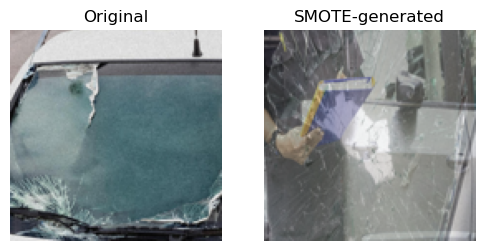

Comparing image 357: Original size (128, 128, 3), SMOTE size (128, 128, 3)


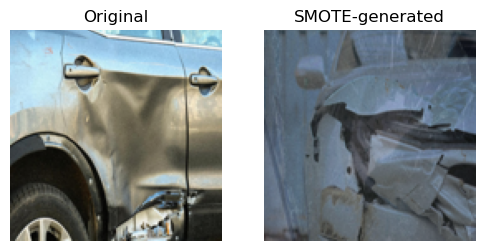

Comparing image 188: Original size (128, 128, 3), SMOTE size (128, 128, 3)


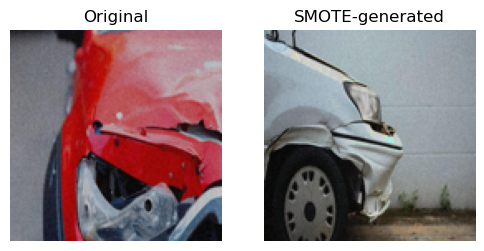

Comparing image 19: Original size (128, 128, 3), SMOTE size (128, 128, 3)


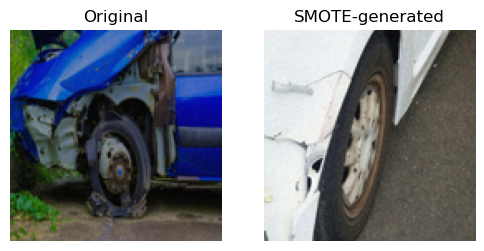

Comparing image 175: Original size (128, 128, 3), SMOTE size (128, 128, 3)


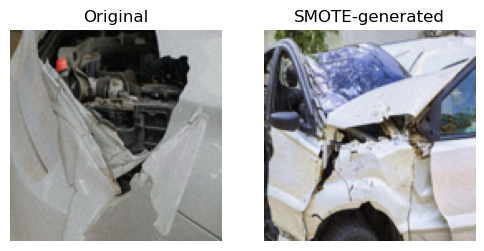

Comparing image 282: Original size (128, 128, 3), SMOTE size (128, 128, 3)


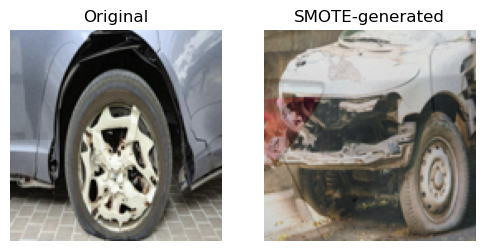

Comparing image 243: Original size (128, 128, 3), SMOTE size (128, 128, 3)


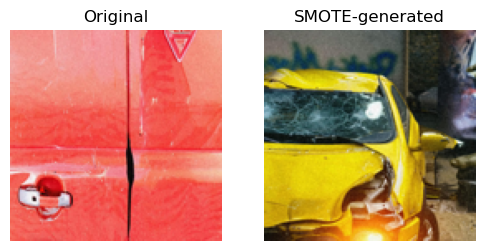

Comparing image 36: Original size (128, 128, 3), SMOTE size (128, 128, 3)


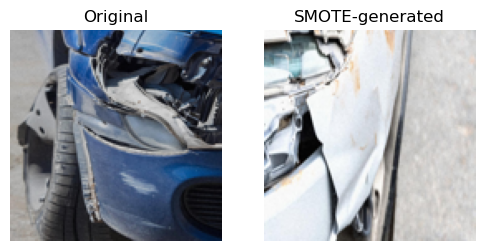

Comparing image 318: Original size (128, 128, 3), SMOTE size (128, 128, 3)


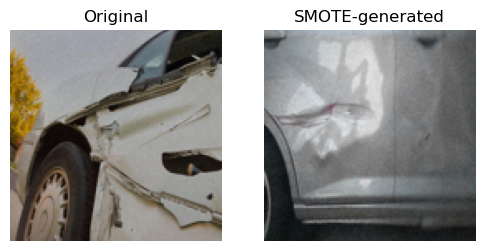

Comparing image 17: Original size (128, 128, 3), SMOTE size (128, 128, 3)


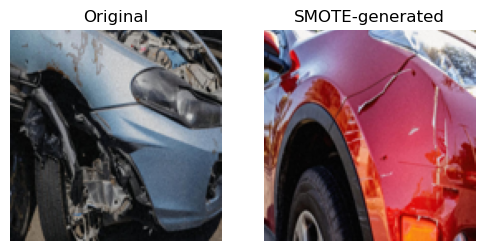

Average MSE between original and SMOTE images: 0.13479128194539997
SMOTE model has been saved to 'smote_model.pkl'


In [29]:
def calculate_image_similarity(original_images, smote_images, num_samples=10):
    mse_values = []

    # take random samples for comparison
    idx = np.random.choice(len(original_images), min(num_samples, len(original_images)), replace=False)

    for i in idx:
        original = original_images[i]
        smote = smote_images[i]

        # print dimensions for debugging
        print(f"Comparing image {i}: Original size {original.shape}, SMOTE size {smote.shape}")

        # MSE between original and SMOTE-generated image
        mse_value = mean_squared_error(original.flatten(), smote.flatten())
        mse_values.append(mse_value)

        # visualize original and SMOTE-generated images
        plt.figure(figsize=(6, 3))
        
        # original image
        plt.subplot(1, 2, 1)
        plt.imshow(original)
        plt.title('Original')
        plt.axis('off')
        
        # SMOTE-generated image
        plt.subplot(1, 2, 2)
        plt.imshow(smote)
        plt.title('SMOTE-generated')
        plt.axis('off')
        
        plt.show()

    # calculate the average MSE
    avg_mse = np.mean(mse_values) if mse_values else np.nan

    print(f'Average MSE between original and SMOTE images: {avg_mse}')

    return avg_mse

# compare original fraud images with the SMOTE-generated images
mse = calculate_image_similarity(fraud_images, X_train_fraud_resampled_images, num_samples=10)

# save the SMOTE model to a file
joblib.dump(smote, 'smote_model.pkl')

# print confirmation
print("SMOTE model has been saved to 'smote_model.pkl'")

DCAE

In [31]:
# load fraud and non-fraud images from the train directories
fraud_images = train_images_fraud
non_fraud_images = train_images_non_fraud

# combine both fraud and non-fraud images
fraud_images = np.array(fraud_images)
non_fraud_images = np.array(non_fraud_images)
combine_images = np.concatenate((fraud_images, non_fraud_images), axis=0)

# labels for fraud and non-fraud images
fraud_labels = np.ones(len(fraud_images))  # 1 for fraud
non_fraud_labels = np.zeros(len(non_fraud_images))  # 0 for non-fraud

# combine labels
combine_labels = np.concatenate((fraud_labels, non_fraud_labels), axis=0)

# output the combined images and labels
print(f"Combined Images Shape: {combine_images.shape}")
print(f"Combined Labels Shape: {combine_labels.shape}")

Combined Images Shape: (6463, 128, 128, 3)
Combined Labels Shape: (6463,)


In [32]:
# split data into train and test sets
X_train_dcae, X_test_dcae, y_train_dcae, y_test_dcae = train_test_split(combine_images, 
                                                             combine_labels, test_size=0.2, random_state=42)

In [33]:
# add noise to the training images
noise_factor = 0.2 # set the noise factor to determine the intensity of the noise
X_train_noisy = X_train_dcae + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_dcae.shape) # add noise to the training images
X_test_noisy = X_test_dcae + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_dcae.shape) # add noise to the testing images
# set values of the noisy images to be within the range [-1, 1]
X_train_noisy = np.clip(X_train_noisy, -1., 1.)
X_test_noisy = np.clip(X_test_noisy, -1., 1.)


In [34]:
# define the DCAE model
input_img = Input(shape=(img_height, img_width, 3))

# encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

# create and compile the DCAE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# train the DCAE model
dcae_model_history = autoencoder.fit(X_train_noisy, X_train_dcae,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test_noisy, X_test_dcae))

# save the DCAE model
autoencoder.save('dcae_model.keras')

Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 98s 597ms/step - loss: 0.0288 - val_loss: 0.0055
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 586ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 94s 581ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 589ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 96s 593ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 587ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 91s 563ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 90s 556ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 90s 556ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 92s 566ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 11/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 90s 558ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 12/20
162/162

In [35]:
# evaluate the model on test data
loss = autoencoder.evaluate(X_test_noisy, X_test_dcae) # compute loss between noisy and original images
print(f"Test loss: {loss}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0028
Test loss: 0.0028302674181759357


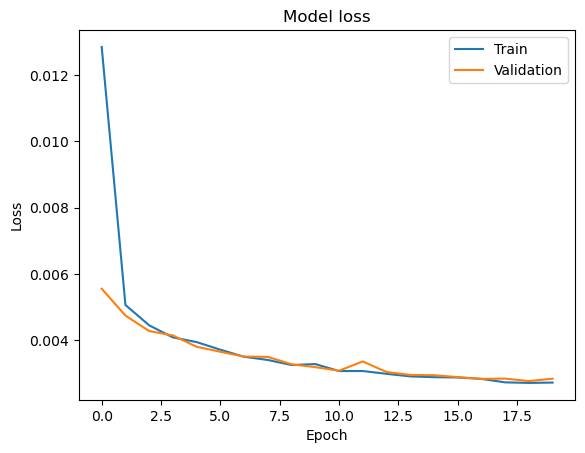

In [36]:
# plot training & validation loss values
plt.plot(dcae_model_history.history['loss'])
plt.plot(dcae_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step


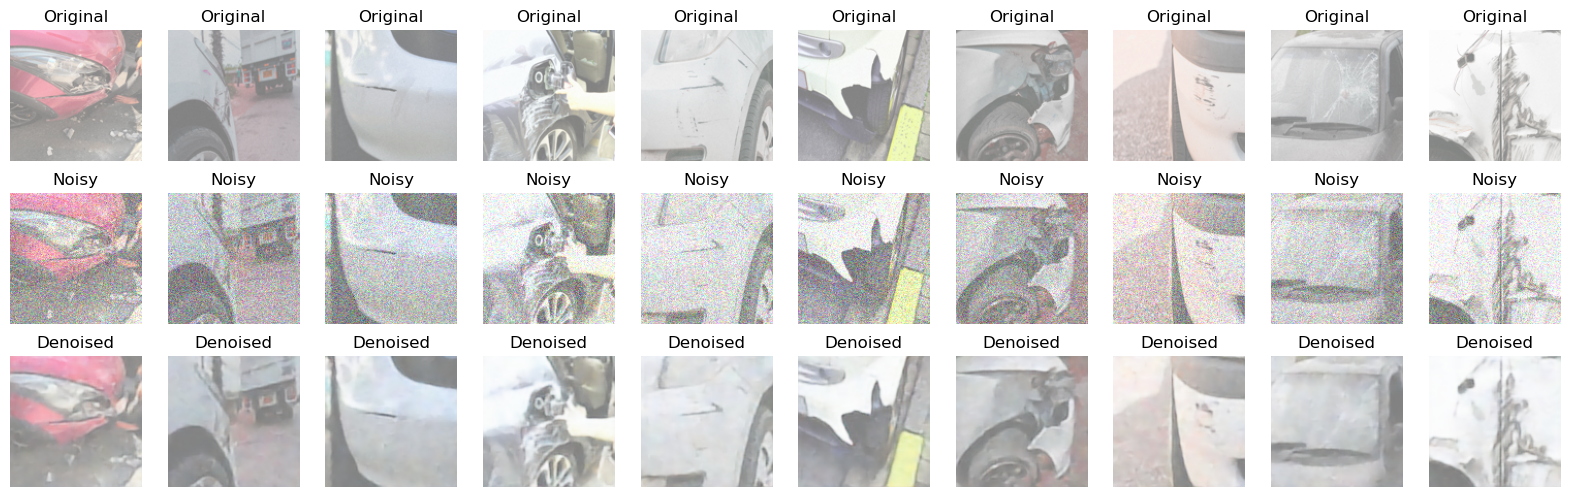

In [37]:
denoised_imgs = autoencoder.predict(X_test_noisy) # predict on noisy test images

# display original, noisy, and denoised images
n = 10  # number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow((X_test_dcae[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title("Original")
    plt.axis("off")

    # display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow((X_test_noisy[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title("Noisy")
    plt.axis("off")
    
    # display denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow((denoised_imgs[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title("Denoised")
    plt.axis("off")

plt.show()